## Dataset loading and visualization

(100,) (100,)


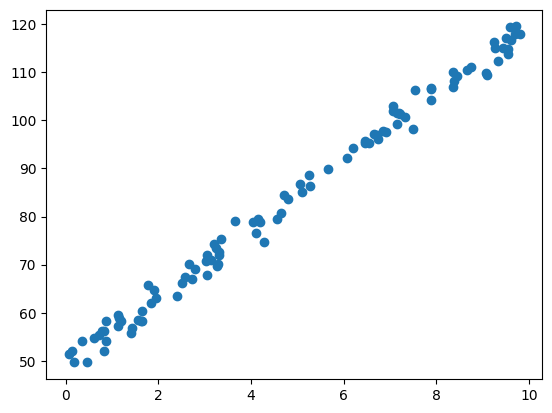

In [14]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
max_x = 10

dataset = np.load('linear_regression_dataset.npz')
x, y = dataset['x'], dataset['y']
dataset_size = x.shape[0]
print(x.shape, y.shape)

def plot(x, y, slope=None, offset_y=None):
    plt.plot(x, y, 'o') # scatter plot of dataset
    if slope is not None:
        plt.plot([0, max_x], [offset_y, offset_y + max_x * slope]) # straight line defined by slope and offset_y
    plt.show()

plot(x, y)

## Linear regression based on hand derived derivative
Implement the `compute_derivatives` function.

plot before training


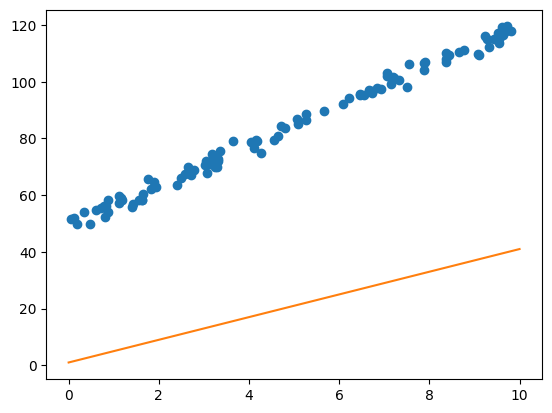

iter: 100, slope: 8.886193268314395, offset_y: 1.9917213448297597, error: 1515.1736724622076
iter: 200, slope: 11.352336813944152, offset_y: 2.6220444024980742, error: 845.256948730454
iter: 500, slope: 13.48934693995678, offset_y: 3.7217831955276575, error: 597.9943086220453


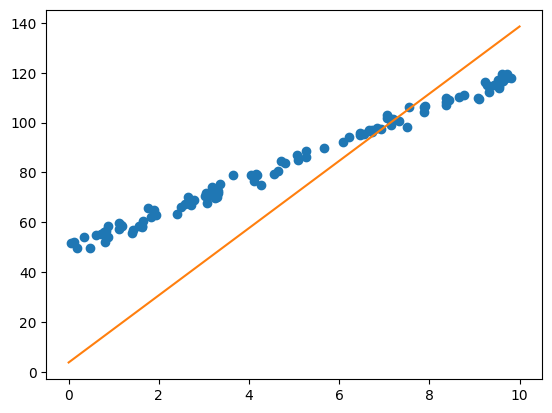

iter: 1000, slope: 13.633138752360182, offset_y: 5.01782598029832, error: 562.2044505224028
iter: 5000, slope: 12.332030441602544, offset_y: 13.845592699105222, error: 362.337325740006
iter: 10000, slope: 11.051472150857288, offset_y: 22.455508528391075, error: 209.83453592597274
iter: 20000, slope: 9.344282864234662, offset_y: 33.93390523138297, error: 71.74936727334212


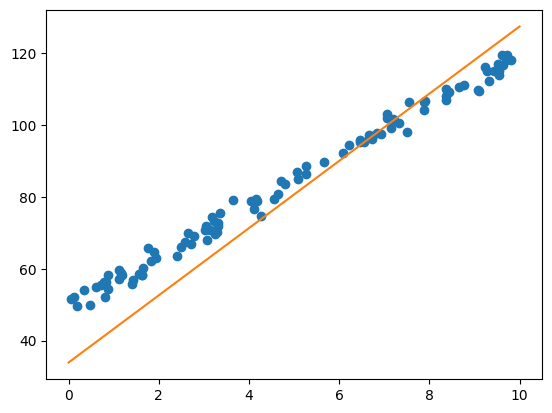

iter: 30000, slope: 8.362780084552877, offset_y: 40.53310214443563, error: 26.10714841793612
iter: 40000, slope: 7.798491335747095, offset_y: 44.32713375216766, error: 11.020719061535988
iter: 50000, slope: 7.474068625368139, offset_y: 46.50841066057447, error: 6.03410017154037


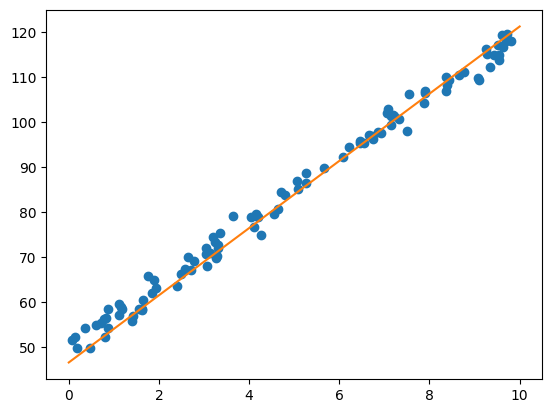

iter: 60000, slope: 7.287550472680562, offset_y: 47.7624774272964, error: 4.38583951511714
iter: 70000, slope: 7.180316853796936, offset_y: 48.4834695440398, error: 3.841028842506483
iter: 80000, slope: 7.118665755213824, offset_y: 48.8979846609383, error: 3.660948909254486
iter: 90000, slope: 7.083221106454616, offset_y: 49.136299031022766, error: 3.6014258786121602
iter: 100000, slope: 7.062843154487317, offset_y: 49.2733114985377, error: 3.5817513312439413
plot after training


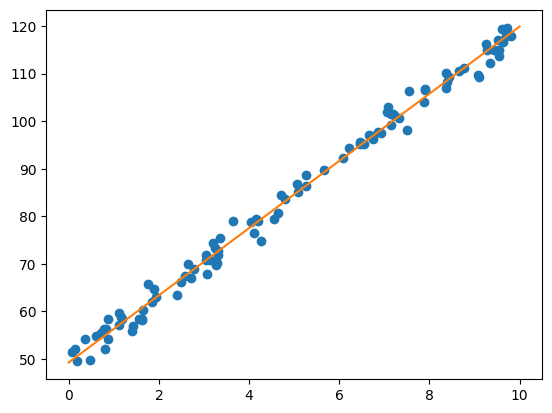

In [15]:
# x.shape: (dataset size,)
# y.shape: (dataset size,)
# slope, offset_y: float
def compute_derivatives(x, y, slope, offset_y):
    slope_derivative = (2/len(x)) * np.sum(slope * x**2 + offset_y * x - x * y)
    offset_y_derivative = (2/len(x)) * np.sum(offset_y + slope * x - y)
    return slope_derivative, offset_y_derivative

def compute_error(x, y, slope, offset_y):
    error = 0
    for i in range(dataset_size):
        error += (offset_y + slope * x[i] - y[i]) ** 2
    error /= dataset_size
    return error

slope = 4 # our initial guess for the slope parameter
offset_y = 1 # our initial guess for the offset parameter
print('plot before training')
plot(x, y, slope, offset_y)
num_steps = 100000
learning_rate = 0.0001
for iteration in range(1, num_steps + 1):
    slope_derivative, offset_y_derivative = compute_derivatives(x, y, slope, offset_y)
    slope = slope - learning_rate * slope_derivative
    offset_y = offset_y - learning_rate * offset_y_derivative
    if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
        print('iter: {}, slope: {}, offset_y: {}, error: {}'.format(iteration, slope, offset_y,
              compute_error(x, y, slope, offset_y)))
    if iteration in [500, 20000, 50000]:
        plot(x, y, slope, offset_y)
print('plot after training')
plot(x, y, slope, offset_y)

## Closed form solution for linear regression
Implement the `compute_weights_cf` function.

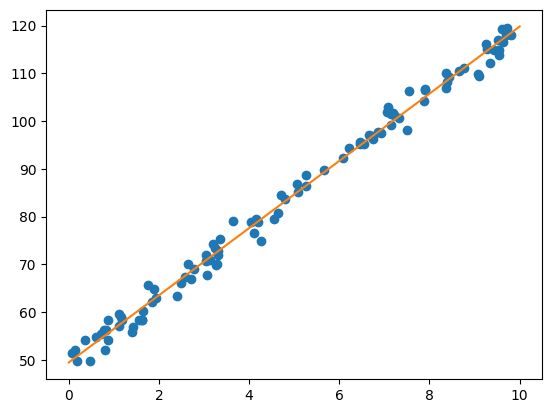

In [25]:
X = np.concatenate([x[:, np.newaxis], np.ones((len(x), 1))], axis=-1)

# X.shape: (dataset size, 2)
# y.shape: (dataset size,)
def compute_weights_cf(X, y):
   # return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
   return np.linalg.pinv(X).dot(y)

w = compute_weights_cf(X, y)

plot(x,y,w[0],w[1])
# plot the solution and calculate the error using the functions from part b)

## Linear regression based on EDF

Implement the `forward` and `backward` method of the class `L2Loss`. Take a look at `edf.py` for inspiration.

In [21]:
import edf

# y shape: (batch size, 1)
# y_hat shape: (batch size, 1)
# output shape: (batch size, 1)
class L2Loss(edf.CompNode):
    def __init__(self, y, y_hat):
        edf.CompNodes.append(self)
        self.y = y
        self.y_hat = y_hat

    def forward(self):
        pass

    def backward(self):
        pass

### Definition of EDF's computation graph
Use EDF to assemble a computational graph for linear regression with the "mean" images as input. You will need the `L2Loss` node that you implemented above. Define the variables `affine_params`, `x_node`, `y_node` and `loss_node`, which the function `train` below expects as input.

In [22]:
edf.clear_compgraph()
# Define the computational graph for Linear Regression below this line in this cell

In [19]:
def train(num_steps, x, y, affine_params, x_node, y_node, loss_node):
    affine_params.A.value[0, 0] = 4 # manually overwrite EDF's random initalization to get consistent results
    affine_params.b.value[0] = 1
    x_node.value = x.reshape(-1, 1)
    y_node.value = y.reshape(-1, 1)
    for iteration in range(1, num_steps + 1):
        edf.Forward()
        edf.Backward(loss_node)
        edf.UpdateParameters()
        error = np.sum(loss_node.value) / dataset_size
        slope = affine_params.A.value[0, 0]
        offset_y = affine_params.b.value[0]
        if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
            print('iter: {}, slope: {}, offset_y: {}, error: {}'.format(iteration, slope, offset_y, error))

edf.learning_rate = learning_rate
train(num_steps, x, y, affine_params, x_node, y_node, loss_node)

NameError: name 'affine_params' is not defined